In [1]:
import time
start_time = time.time()
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

PROJECT_PATH = os.getenv('PROJECT_DIR')
sys.path.append(PROJECT_PATH)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
from src.data_ingestion.iex_data import IexDataFetcher
from src.data_ingestion.weather_data import WeatherDataFetcher
from src.feature_engineering.build_features import FeatureEngineering
from src.model_building.forecast_model import ModelForecaster
from src.db_insertion.db_insertion import DirInsertion
from src.utils import *
from config.paths import *

In [3]:
market_type = 'rtm'

In [4]:
# creating instances
iex_data = IexDataFetcher()
weather_data = WeatherDataFetcher()

featured_data = FeatureEngineering(PROJECT_PATH)
forecasting = ModelForecaster(MODELS_PATH, market_type) 
db_insert = DirInsertion() 

In [5]:
# dam = iex_data._get_processed_data('dam')
# rtm = iex_data._get_processed_data('rtm')
# weather = weather_data._get_processed_weather('weather')
# wind = weather_data._get_processed_weather('wind')
# hydro = weather_data._get_processed_weather('hydro')
# solar = weather_data._get_processed_weather('solar')

In [6]:
dam = load_pickle(PROCESSED_DATA_PATH, 'dam_data')
rtm = load_pickle(PROCESSED_DATA_PATH, 'rtm_data')
weather = load_pickle(PROCESSED_DATA_PATH, 'weather_data')
wind = load_pickle(PROCESSED_DATA_PATH, 'wind_data')
hydro = load_pickle(PROCESSED_DATA_PATH, 'hydro_data')
solar = load_pickle(PROCESSED_DATA_PATH, 'solar_data')
print('Data loaded.')

Data loaded.


In [7]:
rtm = rtm[rtm['datetime'] < datetime.now().strftime('%Y-%m-%d')]

In [8]:
dam = featured_data.shift_date(dam, 1) 
weather = featured_data.shift_date(weather, 2)
hydro = featured_data.shift_date(hydro, 2) 
solar = featured_data.shift_date(solar, 2) 
wind = featured_data.shift_date(wind, 2)

data = featured_data.merge_dataframes([rtm, dam, weather, hydro, solar, wind])

In [9]:
data = featured_data._get_features(data, weather, market_type, task = 'inference')

In [10]:
print('Features created.')

Features created.


In [11]:
forecast_date = forecasting.forecasting_date(data, market_type)

In [12]:
print('forecasting date: ', forecast_date)

forecasting date:  2024-01-18


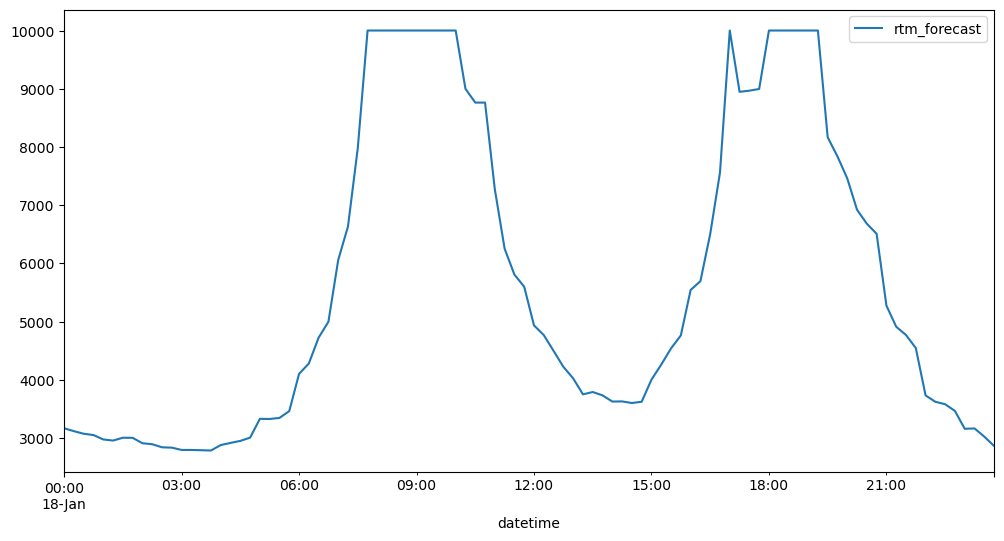

In [13]:
forecast = forecasting.create_forecast(data, forecast_date, market_type)

In [14]:
print(f'{market_type} forecast created.')

rtm forecast created.


In [15]:
dam_forecast = load_pickle(DAM_FORECAST_PATH, f'dam_forecast_{forecast_date}')
rtm_forecast = load_pickle(DIR_FORECAST_PATH, f'{market_type}_forecast_{forecast_date}')

In [16]:
dir_rtm = featured_data.merge_dataframes([dam_forecast, rtm_forecast])

In [17]:
forecasts = dir_rtm.copy()
forecasts['dam_rtm_diff'] = forecasts['dam_forecast'] - forecasts[f'{market_type}_forecast']

# if dam > rtm, make dam_greater = 1, elif if dam < rtm, make dam_greater = 0 else dam 
forecasts.loc[(forecasts['dam_rtm_diff'] > 0), 'dam_greater'] = 1
forecasts.loc[(forecasts['dam_rtm_diff'] < 0), 'dam_greater'] = 0
forecasts.loc[(forecasts['dam_rtm_diff'] == 0), 'dam_greater'] = -1

forecasts = forecasts[['datetime', 'dam_greater']]
forecasts = forecasts.rename(columns = {'dam_greater': f'dir_forecast'})

<Axes: xlabel='datetime'>

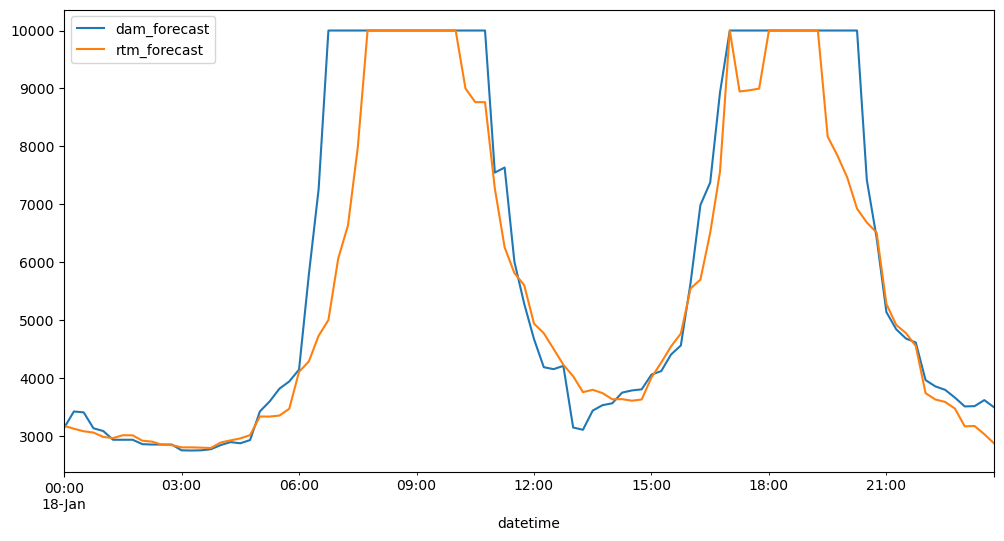

In [18]:
dir_rtm.set_index('datetime')[['dam_forecast', f'{market_type}_forecast']].plot()

In [19]:
db_insert.save_forecast(forecasts, forecast_date, 'dir')

dir forecast inserted successfully


In [20]:
end_time = time.time()
total_time = (end_time - start_time)/60
print(f'Forecasting time: {total_time:.2f} minutes.')

Forecasting time: 1.53 minutes.
